In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg

C:\Users\miche\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Patient of interest

In [2]:
def read_file(filename):
    df = pd.read_csv(filename)

    # Split the column into two new columns
    df[['TIMESTAMP', 'HRV']] = df['TIMESTAMP;HRV'].str.split(';', expand=True)

    # Convert TIMESTAMP & HRV to appropriate data types
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])  # Convert TIMESTAMP to datetime
    df['HRV'] = pd.to_numeric(df['HRV'], errors='coerce')  # Convert HRV to numeric

    # Drop the original column
    df.drop(columns=['TIMESTAMP;HRV'], inplace=True)

    # Set TIMESTAMP as the index
    df.set_index('TIMESTAMP', inplace=True)

    return df  # Return the transformed DataFrame

In [3]:
df_patient_hr = read_file('patient_hr_1.csv')

df_patient_hr

,HRV
TIMESTAMP,
2009-03-04 11:00:00.000,2294.92
2009-03-04 11:00:02.295,631.84
2009-03-04 11:00:02.927,624.02
2009-03-04 11:00:03.551,636.72
2009-03-04 11:00:04.188,625.98
...,...
2009-03-05 08:07:30.918,671.88
2009-03-05 08:07:31.590,669.92
2009-03-05 08:07:32.260,670.90


In [4]:
# check to make sure there are no null values
df_patient_hr.isnull().sum()

HRV    0
dtype: int64

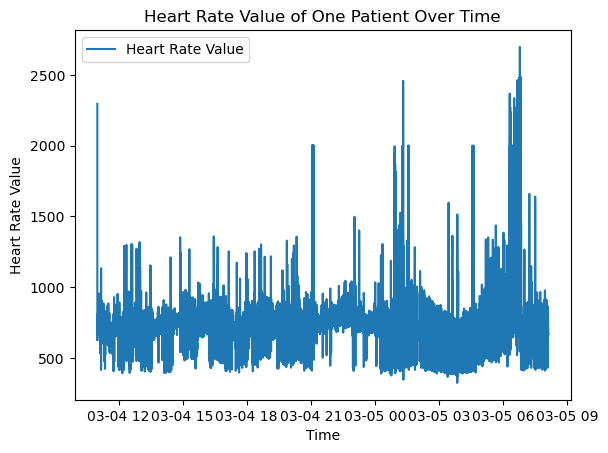

In [5]:
# visualize the time series
plt.plot(df_patient_hr['HRV'], label='Heart Rate Value')
plt.xlabel('Time')
plt.ylabel('Heart Rate Value')
plt.legend()
plt.title('Heart Rate Value of One Patient Over Time')
plt.show();

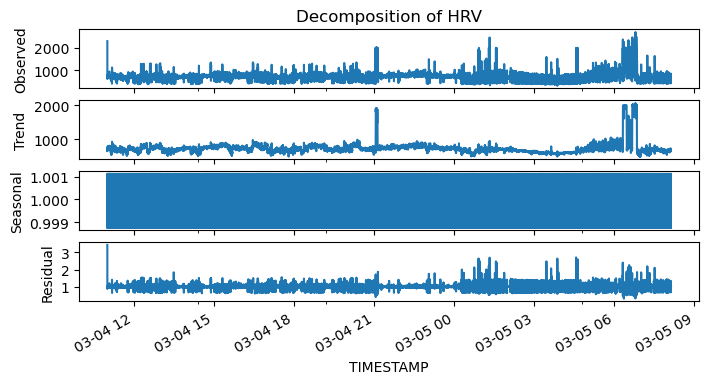

In [6]:
# Checking out the decompositions

# setting the period makes the assumption that the seasonal trend should happen every "period" units (e.g. 10 years, or 5 days)
# can change model='multiplicative' to see if there's a change in seasonal trend
decomp1 = seasonal_decompose(df_patient_hr['HRV'], period=10, model='multiplicative', extrapolate_trend='freq')
# decomp2 = seasonal_decompose(data['Close'], period=5, model='additive', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of HRV')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

- no patterns in residual

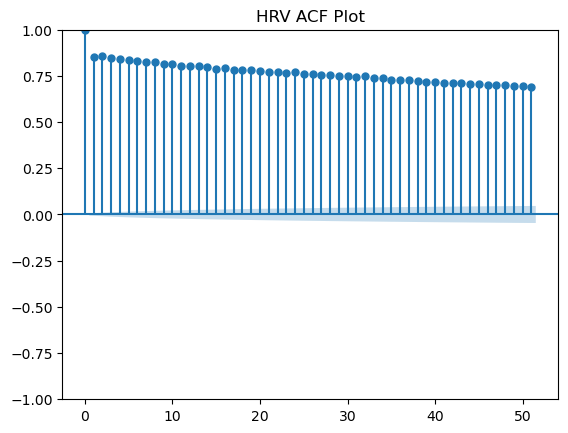

In [7]:
# Autocorrelation Function
# This is used to determine the appropriate lag

# use the original data
series = df_patient_hr['HRV']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();
# Looks like even up to a lag of 10 could provide significant information about the ensuing years

C:\Users\miche\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


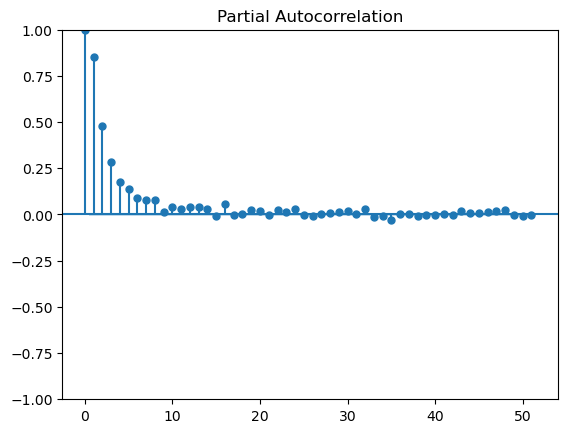

In [8]:
# plot partial autocorrelation function (PACF)
# PACF drops faster, therefore AR model should be better?
plot_pacf(series)
plt.show();

- AR model may be slightly better. This in the partial autocorrelation plot, it doesn't drop immediately.

# Create lag features

In [9]:
for i in range(1, 11):
    df_patient_hr[f'Lag {i}'] = df_patient_hr['HRV'].shift(i)

df_patient_hr = df_patient_hr.dropna()

df_patient_hr.head()

,HRV,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,Lag 10
TIMESTAMP,,,,,,,,,,,
2009-03-04 11:00:08.080,674.80,670.90,656.25,656.25,650.39,632.81,625.98,636.72,624.02,631.84,2294.92
2009-03-04 11:00:08.755,669.92,674.80,670.90,656.25,656.25,650.39,632.81,625.98,636.72,624.02,631.84
2009-03-04 11:00:09.425,679.69,669.92,674.80,670.90,656.25,656.25,650.39,632.81,625.98,636.72,624.02
2009-03-04 11:00:10.104,697.27,679.69,669.92,674.80,670.90,656.25,656.25,650.39,632.81,625.98,636.72
2009-03-04 11:00:10.802,676.76,697.27,679.69,669.92,674.80,670.90,656.25,656.25,650.39,632.81,625.98


# Split data into training and testing set

In [10]:
# Split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
# Take instead the first 80% for the training, then we'll see if the first 80% of MLB history can be used to predict the next 20%
train_size = int(.8 * len(df_patient_hr))
train_data = df_patient_hr[:train_size]
test_data = df_patient_hr[train_size:]

# put the y feature (the current SO9) in arrays
y_train = np.array(train_data['HRV']).reshape(-1,1)
y_test = np.array(test_data['HRV']).reshape(-1,1)

# AR Model

## Manually

In [60]:
# Fit the model using OLS:
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
print("Model coefficients:", w)

# Predictions
# For AR(10), we need the last 10 values from training to start predicting
y_pred = []
# Get the last 10 values from training data (in reverse order for easy updating)
last_values = np.array(train_data['HRV'].iloc[-10:].values[::-1])

for i in range(len(y_test)):
    # Create feature vector with the 10 most recent values (as a row vector)
    features = last_values.reshape(1, -1)  # Shape (1,10)
    # Predict next value using matrix multiplication correctly
    next_pred = np.dot(features, w).item()  # Dot product of (1,10) and (10,) vectors
    y_pred.append(next_pred)
    # Update the last_values array by removing the oldest value and adding the new prediction
    last_values = np.roll(last_values, -1)  # Roll right to remove oldest value
    last_values[-1] = next_pred  # Add new prediction as most recent value

Model coefficients: [[0.15946337]
 [0.23317875]
 [0.18493072]
 [0.10183479]
 [0.09220052]
 [0.02996457]
 [0.03375129]
 [0.09375674]
 [0.0262305 ]
 [0.04411958]]


In [61]:
# Put predictions into a data frame for plotting purposes
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
pred_data.set_index('Time', inplace=True)
pred_data.head()

,pred HRV
Time,
2009-03-05 03:49:47.892,566.697609
2009-03-05 03:49:48.459,567.362858
2009-03-05 03:49:48.911,567.887521
2009-03-05 03:49:49.589,567.635557
2009-03-05 03:49:50.159,568.150095


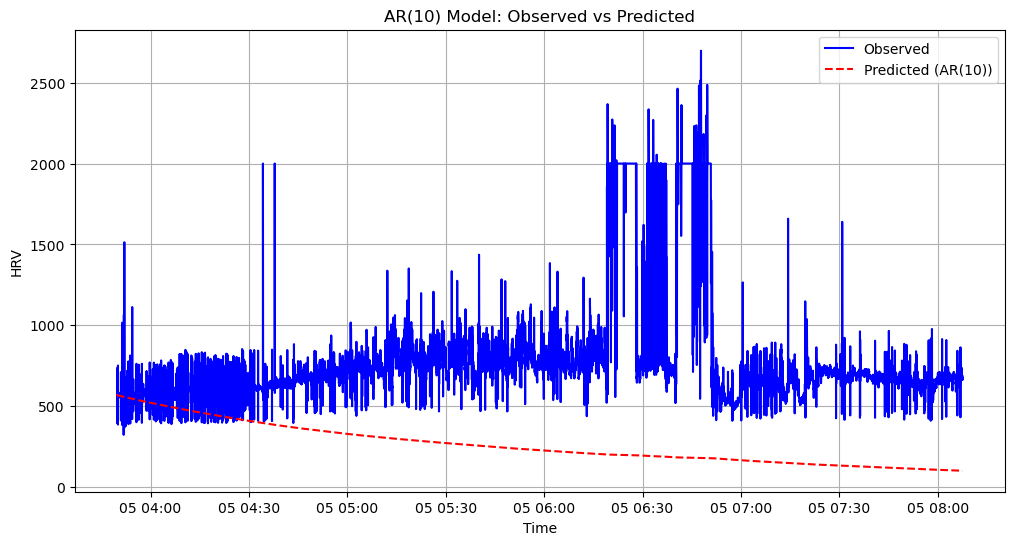

In [62]:
# Plot observed versus predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['HRV'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred HRV'], 'r--', label='Predicted (AR(10))')
plt.legend()
plt.title('AR(10) Model: Observed vs Predicted')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.grid(True)
plt.show()

In [59]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 449.87
Root Mean Squared Error: 539.52


## Using Package

In [69]:
# Using statsmodels AutoReg function
ar_model = AutoReg(y_train, lags=10, trend='n') # the default is to add an intercept (or, trend='c'), 
# using trend='n' is more in line with traditional AR(p) models, but may result in a nonstationary model
ar_results = ar_model.fit()
ar_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                85971
Model:                    AutoReg(10)   Log Likelihood             -453029.563
Method:               Conditional MLE   S.D. of innovations             47.051
Date:                Tue, 08 Apr 2025   AIC                         906081.125
Time:                        17:36:26   BIC                         906184.104
Sample:                            10   HQIC                        906112.591
                                85971                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
y.L1           0.1594      0.003     46.793      0.000       0.153       0.166
y.L2           0.2331      0.003     67.586      0.000       0.226       0.240
y.L3           0.1849      0.004     52.450      0.000       0.178       0.192
y.L4           0.1018      0.004     28.444      0.000       0.095       0.109
y.L5           0.0922      0.004     25.636      0.000       0.085       0.099
y.L6           0.0299      0.004      8.322      0.000       0.023       0.037
y.L7           0.0337      0.004      9.408      0.000       0.027       0.041
y.L8           0.0937      0.004     26.569      0.000       0.087       0.101
y.L9           0.0262      0.003      7.589      0.000       0.019       0.033
y.L10          0.0445      0.003     13.075      0.000       0.038       0.051
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0001           -0.0000j            1.0001           -0.0000
AR.2             1.0592           -0.8299j            1.3456           -0.1058
AR.3             1.0592           +0.8299j            1.3456            0.1058
AR.4            -1.3345           -0.0000j            1.3345           -0.5000
AR.5            -1.0282           -0.8362j            1.3253           -0.3913
AR.6            -1.0282           +0.8362j            1.3253            0.3913
AR.7             0.2664           -1.4334j            1.4580           -0.2208
AR.8             0.2664           +1.4334j            1.4580            0.2208
AR.9            -0.4241           -1.5191j            1.5772           -0.2933
AR.10           -0.4241           +1.5191j            1.5772            0.2933
------------------------------------------------------------------------------
"""

In [70]:
print(ar_results.params)
print(abs(ar_results.roots))

[0.15944107 0.23312753 0.18490529 0.10181381 0.09215762 0.02991667
 0.03367575 0.09366487 0.02617746 0.04454922]
[1.00014651 1.34563461 1.34563461 1.33453079 1.32532    1.32532
 1.45797076 1.45797076 1.57720123 1.57720123]


For the stationarity assumption to be met, the absolute value of the roots should be greater than 1. In general, based on the roots from above, all of the values are greater than 1. Therefore, it can be said that the stationarity assumption is met.

In [65]:
# the predictions
ar_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': ar_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred HRV
Time,
2009-03-05 03:49:47.892,566.697308
2009-03-05 03:49:48.459,566.531262
2009-03-05 03:49:48.911,566.554738
2009-03-05 03:49:49.589,566.281573
2009-03-05 03:49:50.159,566.322788


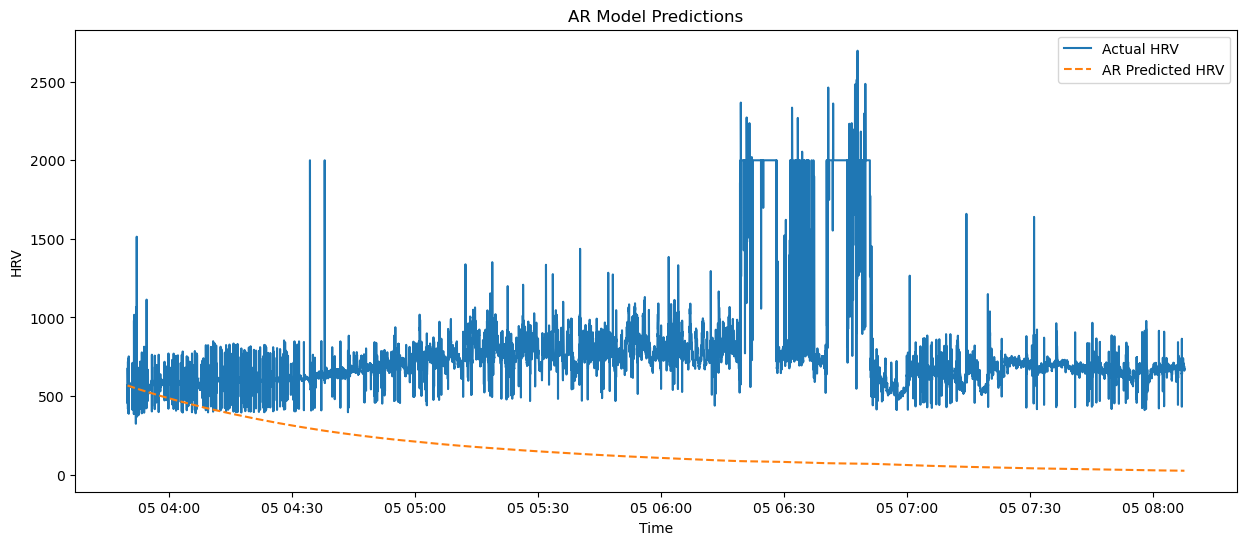

In [67]:
# make the plot
plt.figure(figsize=(15, 6))

plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'AR Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('AR Model Predictions')
plt.show();

In [68]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 548.16
Root Mean Squared Error: 630.34


# MA model

## Manually

In [75]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt

# Function to calculate the error terms (residuals)
def ma_errors(params, y):
    """
    Calculate residuals for MA(10) model
    params: theta parameters (MA coefficients)
    y: observed values
    """
    theta = params
    n = len(y)
    errors = np.zeros(n)
    # Initialize past errors (we don't know true past errors, so we start with zeros)
    past_errors = np.zeros(10)
    
    # Calculate errors
    for t in range(n):
        # Predict using weighted sum of past error terms
        prediction = np.sum(theta * past_errors)
        # Calculate current error
        errors[t] = y[t] - prediction
        # Update past errors by shifting and adding new error
        past_errors = np.roll(past_errors, -1)
        past_errors[-1] = errors[t]
        
    return errors

# Function to calculate the sum of squared errors (objective function for optimization)
def ma_objective(params, y):
    """
    Objective function to minimize (sum of squared errors)
    """
    errors = ma_errors(params, y)
    return np.sum(errors**2)

# Fit MA(10) model using optimization
def fit_ma10(y_train):
    """
    Fit MA(10) model by minimizing sum of squared errors
    """
    # Initial guess for theta parameters (all zeros)
    initial_theta = np.zeros(10)
    
    # Use optimization to find the best theta parameters
    result = optimize.minimize(ma_objective, initial_theta, args=(y_train,), 
                             method='L-BFGS-B')
    
    if result.success:
        return result.x
    else:
        print("Optimization failed:", result.message)
        return initial_theta

# Predict using MA(10) model
def predict_ma10(theta, y_test_len, training_errors):
    """
    Make predictions using MA(10) model
    theta: MA coefficients
    y_test_len: number of steps to predict
    training_errors: last 10 error terms from training data
    """
    # Initialize predictions array
    predictions = np.zeros(y_test_len)
    # Start with last 10 error terms from training
    past_errors = np.array(training_errors[-10:])
    
    for t in range(y_test_len):
        # Predict using weighted sum of past error terms
        predictions[t] = np.sum(theta * past_errors)
        # Since we don't know the true error for test data,
        # we assume the error is zero for future predictions
        new_error = 0  
        # Update past errors
        past_errors = np.roll(past_errors, -1)
        past_errors[-1] = new_error
        
    return predictions

# Main process to fit MA(10) and make predictions
def run_ma10_model(train_data, test_data):
    # Convert Series to numpy arrays
    y_train = np.array(train_data['HRV'])
    
    # Fit MA(10) model
    print("Fitting MA(10) model...")
    theta = fit_ma10(y_train)
    print("MA coefficients (theta):", theta)
    
    # Calculate errors from training data
    training_errors = ma_errors(theta, y_train)
    
    # Make predictions for test period
    print("Making predictions...")
    y_pred = predict_ma10(theta, len(test_data), training_errors)
    
    # Put predictions into a data frame for plotting purposes
    pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
    pred_data.set_index('Time', inplace=True)
    
    # Plot observed versus predicted
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data['HRV'], 'b-', label='Observed')
    plt.plot(pred_data.index, pred_data['pred HRV'], 'r--', label='Predicted (MA(10))')
    plt.legend()
    plt.title('MA(10) Model: Observed vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('HRV')
    plt.grid(True)
    plt.show()
    
    return pred_data, theta

Fitting MA(10) model...
MA coefficients (theta): [0.30907467 0.61021865 1.05380735 1.46577846 1.85209265 2.12452606
 2.12930208 1.97633201 1.63159096 1.15259778]
Making predictions...


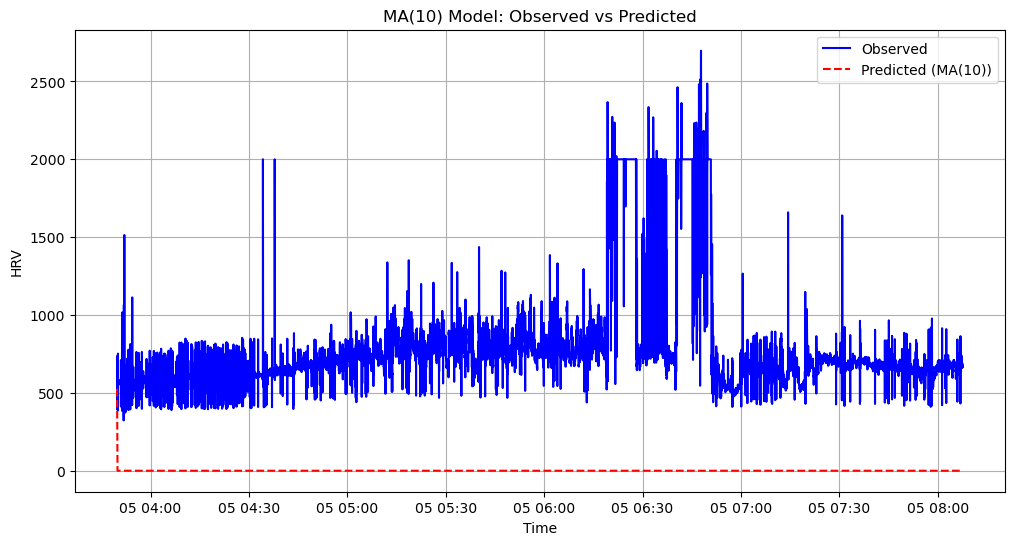

,pred HRV
Time,
2009-03-05 03:49:47.892,526.335030
2009-03-05 03:49:48.459,482.733838
2009-03-05 03:49:48.911,420.423837
2009-03-05 03:49:49.589,344.903843
2009-03-05 03:49:50.159,265.556021


In [76]:
pred_data, theta = run_ma10_model(train_data, test_data)
pred_data.head()

In [77]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 719.49
Root Mean Squared Error: 759.47


## Using Package

In [23]:
ma_model = ARIMA(y_train, order=(0, 0, 10))
ma_results = ma_model.fit()

#summary of the model
ma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                85979
Model:                ARIMA(0, 0, 10)   Log Likelihood             -462557.845
Date:                Tue, 08 Apr 2025   AIC                         925139.690
Time:                        16:50:27   BIC                         925252.032
Sample:                             0   HQIC                        925174.016
                              - 85979                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        704.6714      0.910    774.651      0.000     702.888     706.454
ma.L1          0.3349      0.001    507.775      0.000       0.334       0.336
ma.L2          0.4385      0.001    528.386      0.000       0.437       0.440
ma.L3          0.4487      0.001    434.176      0.000       0.447       0.451
ma.L4          0.4211      0.001    337.535      0.000       0.419       0.424
ma.L5          0.4339      0.001    346.776      0.000       0.431       0.436
ma.L6          0.3455      0.001    284.678      0.000       0.343       0.348
ma.L7          0.3057      0.001    273.000      0.000       0.303       0.308
ma.L8          0.2982      0.001    271.908      0.000       0.296       0.300
ma.L9          0.1922      0.001    175.647      0.000       0.190       0.194
ma.L10         0.1659      0.001    164.357      0.000       0.164       0.168
sigma2      2756.9797      2.144   1285.788      0.000    2752.777    2761.182
===================================================================================
Ljung-Box (L1) (Q):                  34.36   Jarque-Bera (JB):          39280979.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                             3.94
Prob(H) (two-sided):                  0.00   Kurtosis:                       107.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
# getting the predictions works the same as in AR(p)
# but note that MA(q) models are even worse at long-term broadcasting
# and that everything after order q=1 is simply predicted at the mean
ma_pred = ma_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': ma_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred HRV
Time,
85979,599.299483
85980,609.912547
85981,622.865870
85982,636.975978
85983,650.229758


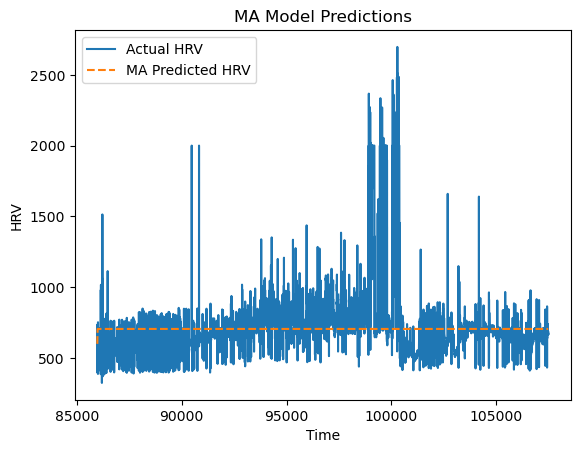

In [25]:
plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'MA Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('MA Model Predictions')
plt.show();

In [ ]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

# ARIMA Model

## Manually

In [11]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt

# Custom implementation of ARIMA(10,0,10) which is an ARMA(10,10) model
# since the integration order is 0

def arma_errors(params, y):
    """
    Calculate residuals for ARMA(10,10) model
    
    params: Combined AR and MA parameters
            first 10 elements are AR coefficients (phi)
            next 10 elements are MA coefficients (theta)
    y: observed values
    """
    # Split parameters into AR and MA coefficients
    phi = params[:10]    # AR coefficients
    theta = params[10:]  # MA coefficients
    
    n = len(y)
    errors = np.zeros(n)
    
    # We need to keep track of past values and past errors
    past_values = np.zeros(10)  # Initialize with zeros
    past_errors = np.zeros(10)  # Initialize with zeros
    
    # Calculate errors iteratively
    for t in range(n):
        # Predict using AR component (weighted sum of past values)
        # and MA component (weighted sum of past errors)
        ar_component = np.sum(phi * past_values)
        ma_component = np.sum(theta * past_errors)
        
        # Prediction is the sum of both components
        prediction = ar_component + ma_component
        
        # Calculate current error
        errors[t] = y[t] - prediction
        
        # Update past values by shifting and adding current observation
        past_values = np.roll(past_values, -1)
        past_values[-1] = y[t]
        
        # Update past errors by shifting and adding current error
        past_errors = np.roll(past_errors, -1)
        past_errors[-1] = errors[t]
        
    return errors

def arma_objective(params, y):
    """
    Objective function to minimize (sum of squared errors)
    """
    errors = arma_errors(params, y)
    return np.sum(errors**2)

def fit_arma(y_train):
    """
    Fit ARMA(10,10) model by minimizing sum of squared errors
    """
    # Initial guess for parameters (all close to zero)
    # First 10 parameters are AR coefficients, next 10 are MA coefficients
    initial_params = np.random.normal(0, 0.1, 20)
    
    # Add constraints to ensure stationarity and invertibility
    # For simplicity, we'll constrain all parameters to be between -0.99 and 0.99
    bounds = [(-0.99, 0.99) for _ in range(20)]
    
    # Use optimization to find the best parameters
    result = optimize.minimize(arma_objective, initial_params, args=(y_train,), 
                              method='L-BFGS-B', bounds=bounds)
    
    if result.success:
        return result.x
    else:
        print("Optimization failed:", result.message)
        return initial_params

def predict_arma(params, y_test_len, last_values, last_errors):
    """
    Make predictions using ARMA(10,10) model
    
    params: Combined AR and MA parameters
    y_test_len: number of steps to predict
    last_values: last 10 values from training data
    last_errors: last 10 error terms from training data
    """
    # Split parameters into AR and MA coefficients
    phi = params[:10]    # AR coefficients
    theta = params[10:]  # MA coefficients
    
    # Initialize predictions array
    predictions = np.zeros(y_test_len)
    
    # Start with last values and errors from training
    past_values = np.array(last_values[-10:])
    past_errors = np.array(last_errors[-10:])
    
    for t in range(y_test_len):
        # Calculate prediction using AR and MA components
        ar_component = np.sum(phi * past_values)
        ma_component = np.sum(theta * past_errors)
        prediction = ar_component + ma_component
        
        # Store prediction
        predictions[t] = prediction
        
        # Update past values
        past_values = np.roll(past_values, -1)
        past_values[-1] = prediction
        
        # Since we don't know the true error for test data,
        # we assume it's zero for future predictions
        new_error = 0
        past_errors = np.roll(past_errors, -1)
        past_errors[-1] = new_error
        
    return predictions

def run_arma_model(train_data, test_data):
    """
    Run the complete ARMA(10,10) modeling process
    """
    # Convert Series to numpy arrays
    y_train = np.array(train_data['HRV'])
    
    # Fit ARMA(10,10) model
    print("Fitting ARMA(10,10) model...")
    params = fit_arma(y_train)
    phi = params[:10]
    theta = params[10:]
    print("AR coefficients (phi):", phi)
    print("MA coefficients (theta):", theta)
    
    # Calculate errors from training data
    training_errors = arma_errors(params, y_train)
    
    # Get last values from training data
    last_values = y_train[-10:]
    
    # Make predictions for test period
    print("Making predictions...")
    y_pred = predict_arma(params, len(test_data), last_values, training_errors)
    
    # Put predictions into a data frame for plotting purposes
    pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
    pred_data.set_index('Time', inplace=True)
    
    # Plot observed versus predicted
    plt.figure(figsize=(12, 6))
    plt.plot(test_data.index, test_data['HRV'], 'b-', label='Observed')
    plt.plot(pred_data.index, pred_data['pred HRV'], 'r--', label='Predicted (ARMA(10,10))')
    plt.legend()
    plt.title('ARMA(10,10) Model: Observed vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('HRV')
    plt.grid(True)
    plt.show()
    
    return pred_data, params

Fitting ARMA(10,10) model...


C:\Users\miche\AppData\Local\Temp\ipykernel_25144\1158396456.py:57: RuntimeWarning: overflow encountered in square
  return np.sum(errors**2)
C:\Users\miche\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\miche\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


AR coefficients (phi): [ 0.56751318  0.57201719  0.38115055  0.34733313  0.17099211  0.05796404
  0.11158426 -0.05929624 -0.44221412 -0.71143911]
MA coefficients (theta): [-0.24262836 -0.08074911  0.27478869  0.3628959   0.55591888  0.73026959
  0.69012737  0.78375837  0.97257228  0.93537889]
Making predictions...


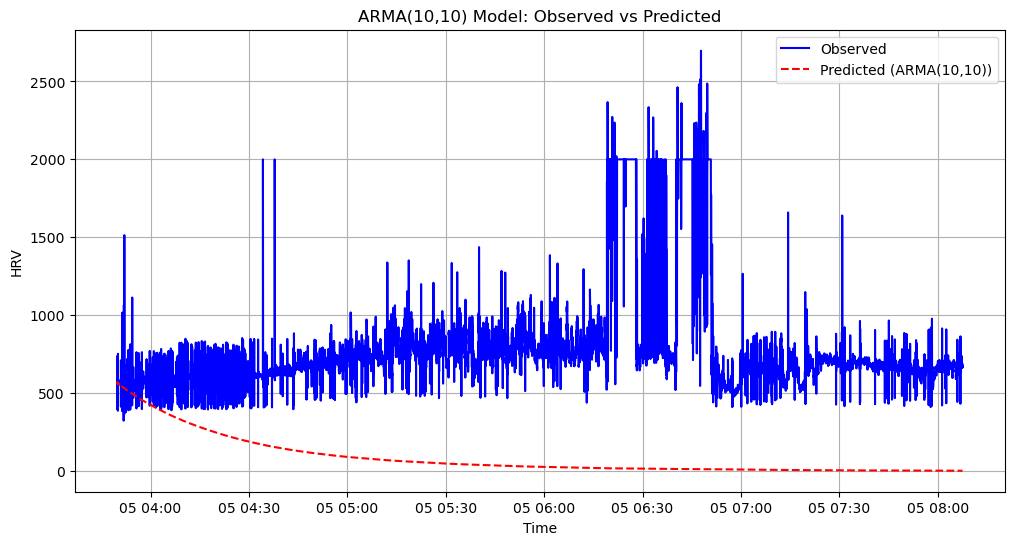

,pred HRV
Time,
2009-03-05 03:49:47.892,565.843465
2009-03-05 03:49:48.459,567.403143
2009-03-05 03:49:48.911,564.642362
2009-03-05 03:49:49.589,565.101185
2009-03-05 03:49:50.159,566.633410


In [12]:
pred_data, params = run_arma_model(train_data, test_data)
pred_data.head()

In [13]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 622.62
Root Mean Squared Error: 694.12


## Using Package

In [26]:
# For AR(p), you would do ARIMA(series, order=(p, 0, 0))
# For MA(q), you would do ARIMA(series, order=(0, 0, q))
# For ARIMA(p,q), it's ARIMA(series, order=(p, 0, q))
# And for ARIMA(p, d, q), it's ARIMA(series, order=(p,d,q))
# though you should investigate a little bit more outside of class just what combining them entails before trusting
# here's the docs: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# CHANGE NUMBER HERE
arima_model = ARIMA(y_train, order=(10, 0, 10))
arima_results = arima_model.fit()

#summary of the model
arima_results.summary()
# Interpretation: coef. of the constant is 3.8981 which works as the mean of the dataset 
# coefficient of the noise value ma.L1 is .7172, but the P>|z| tells us that this has a significant impact on the output
# (note, if we used the differenced data, the constant is no longer interpretable as the mean/level of the series)

C:\Users\miche\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                85979
Model:               ARIMA(10, 0, 10)   Log Likelihood             -452885.940
Date:                Tue, 08 Apr 2025   AIC                         905815.881
Time:                        17:00:27   BIC                         906021.841
Sample:                             0   HQIC                        905878.812
                              - 85979                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        704.6695      8.064     87.386      0.000     688.865     720.474
ar.L1          0.2797      0.027     10.504      0.000       0.228       0.332
ar.L2          0.2372      0.021     11.444      0.000       0.197       0.278
ar.L3          0.0615      0.009      6.764      0.000       0.044       0.079
ar.L4          0.2265      0.011     21.286      0.000       0.206       0.247
ar.L5          0.0883      0.010      9.014      0.000       0.069       0.107
ar.L6          0.1179      0.008     13.980      0.000       0.101       0.134
ar.L7         -0.0380      0.008     -4.861      0.000      -0.053      -0.023
ar.L8          0.6967      0.009     74.699      0.000       0.678       0.715
ar.L9         -0.3479      0.017    -20.162      0.000      -0.382      -0.314
ar.L10        -0.3292      0.017    -19.862      0.000      -0.362      -0.297
ma.L1         -0.1261      0.027     -4.737      0.000      -0.178      -0.074
ma.L2         -0.0218      0.018     -1.221      0.222      -0.057       0.013
ma.L3          0.0570      0.011      5.112      0.000       0.035       0.079
ma.L4         -0.1514      0.010    -15.559      0.000      -0.170      -0.132
ma.L5         -0.0410      0.009     -4.769      0.000      -0.058      -0.024
ma.L6         -0.1426      0.007    -21.506      0.000      -0.156      -0.130
ma.L7         -0.0001      0.008     -0.014      0.989      -0.016       0.015
ma.L8         -0.6661      0.008    -81.597      0.000      -0.682      -0.650
ma.L9          0.2122      0.016     13.272      0.000       0.181       0.244
ma.L10         0.1946      0.013     14.957      0.000       0.169       0.220
sigma2      2189.9950      1.416   1546.219      0.000    2187.219    2192.771
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):          83021118.27
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               2.38   Skew:                             4.01
Prob(H) (two-sided):                  0.00   Kurtosis:                       155.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
# getting the predictions works the same as in AR(p)
# but note that MA(q) models are even worse at long-term broadcasting
# and that everything after order q=1 is simply predicted at the mean
arima_pred = arima_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': arima_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred HRV
Time,
85979,570.931216
85980,572.274242
85981,573.856560
85982,574.366730
85983,574.045112


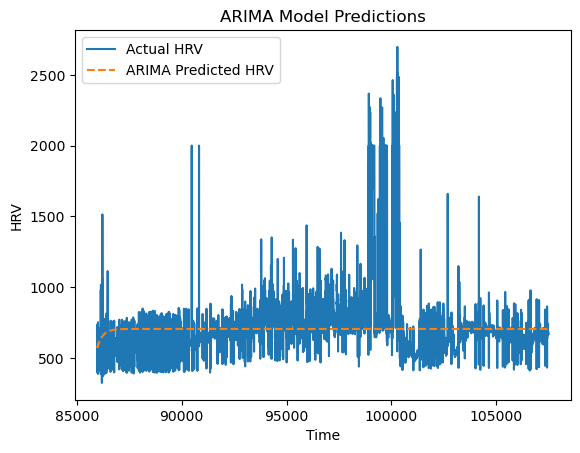

In [28]:
plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'ARIMA Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show();

In [29]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 115.65
Root Mean Squared Error: 242.77


The mean absolute error and root mean squared error for ARIMA (using both AR and MA together) is better than when just using AR.